# pytorch for generating music reviews

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print('cuda.is_available:', torch.cuda.is_available())
cuda = torch.device('cuda')
print(cuda)

cuda.is_available: True
cuda


## Data

In [2]:
import numpy as np
import os
import pandas as pd

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '..', 'datasets')

blog_content_file = os.path.join(DATA_DIR, f'blog_content_en_sample.json')
blog_content_df = pd.read_json(blog_content_file)
print(f'total word_count: {sum(blog_content_df.word_count)}; char_count: {sum([len(w) for w in blog_content_df.content])}')
blog_content_df.head().content

total word_count: 241026; char_count: 1417998


0    New Music\n\nMt. Joy reached out to us with th...
1    Folk rockers Mt. Joy have debuted their new so...
2    You know we're digging Mt. Joy.\n\nTheir new s...
3    Nothing against the profession, but the U.S. h...
4    Connecticut duo **Opia** have released a guita...
Name: content, dtype: object

In [3]:
from sklearn.model_selection import train_test_split

train_text, test_text = train_test_split(blog_content_df.content, test_size=0.2, random_state=42)
print(f'train_text word_count: {sum([len(t) for t in train_text])}; test_text word_count: {sum([len(t) for t in test_text])}')

train_text word_count: 1113633; test_text word_count: 304365


Create inputs...

In [4]:
def padStart(order):
    return '\0' * order

In [5]:
N_FAC = 42 # number of latent factors
N_HIDDEN = 128
EPOCHS = 5
ORDER = 4

def createInputs(texts_arr, print_info=False):
    # shuffle inputs
    texts_arr = texts_arr.sample(frac=1).reset_index(drop=True)
    
    # pad each new text with leading '\0' so that we learn how to start
    texts = ''.join([padStart(ORDER) + text for text in texts_arr])

    chars = sorted(list(set(texts)))
    vocab_size = len(chars)
    if print_info:
        print('vocab_size:', vocab_size)
        print(chars)
        print()

    char_to_idx = {c: i for i, c in enumerate(chars)}
    idx_to_char = {i: c for i, c in enumerate(chars)}

    idx = [char_to_idx[text] for text in texts]
    # create n-gram batches, where each row i of 'xs' contains the first ORDER characters in sequence,
    # and each row i of 'y' contains the target char for that sequence
    batches = [[idx[i+o] for i in range(len(idx)-ORDER-1)] for o in range(ORDER+1)]

    xs = np.stack(batches[:-1], axis=1) # history
    ys = np.stack(batches[-1:][0]) # target

    if print_info:
        print('first 8 chars in text:', idx[:9])
        print(f'each column below is one sequence of {ORDER+1} characters from the text:')
        print(xs[:ORDER, :])
        print('', ys[:ORDER])
        print()
        print(xs.shape, ys.shape)
        
    return xs, ys, vocab_size, char_to_idx, idx_to_char

_, _, vocab_size, _, _ = createInputs(train_text, True)

vocab_size: 96
['\x00', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']

first 8 chars in text: [0, 0, 0, 0, 36, 80, 83, 79, 2]
each column below is one sequence of 5 characters from the text:
[[ 0  0  0  0]
 [ 0  0  0 36]
 [ 0  0 36 80]
 [ 0 36 80 83]]
 [36 80 83 79]

(1118696, 4) (1118696,)


##  with n-grams

Another [n-gram music reviews](https://github.com/iconix/openai/blob/master/nbs/n-gram%20music%20reviews.ipynb) model, implemented this time in PyTorch.

**TODO**: differences in models

Guiding PyTorch tutorial: [An Example: N-Gram Language Modeling](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#an-example-n-gram-language-modeling)

In [6]:
# TODO: draw computational graph
class NGramLanguageModel(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, n_fac, order):
        super(NGramLanguageModel, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, n_fac)
        self.linear1 = nn.Linear(order * n_fac, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs.cuda()).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        output = F.log_softmax(out, dim=1)
        return output

In [6]:
import math
import time

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

In [8]:
def trainNGram(model, xs, ys, order=4, criterion=nn.NLLLoss(), optimizer=None):
    # TODO: switch default criterion to crossentropy_loss
    
    for i in range(xs.shape[0]):
        # Step 1. Prepare the inputs to be passed to the model
        # (i.e., wrap integer indices in variables)
        #xs_tensor = torch.tensor(xs[i], dtype=torch.long, device=cuda)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # order words
        output = model(torch.tensor(xs[i], dtype=torch.long, device=cuda))

        # Step 4. Compute your loss function
        loss = criterion(output, torch.tensor([ys[i]], dtype=torch.long, device=cuda))
        
        # Step 5. Do the backward pass and update gradient
        loss.backward()
        if optimizer:
            optimizer.step()
        
        print_every = 5000
        if i % print_every == 0:
            print(f'{timeSince(start)} ({i} {i / xs.shape[0] * 100:.2f}%) {loss:.4f}')
    
    return output, loss.item()

In [9]:
def sampleNGram(model, order=4, max_length=20):
    with torch.no_grad(): # no need to track history in sampling
        input = '\0' * order

        output_idx = [char_to_idx[c] for c in input[-order:]]

        for i in range(max_length):
            h_idxs = torch.tensor(output_idx[-order:], dtype=torch.long, device=cuda)
            output = model(h_idxs)
            # sample from
            p = [np.exp(logp) for logp in output[0].data.cpu().numpy()]
            # normalize so that probabilities sum to 1 (within tolerance)
            # https://stackoverflow.com/questions/46539431/np-random-choice-probabilities-do-not-sum-to-1
            p /= sum(p)
            idx = np.random.choice(range(output.size(1)), 1, p=p)[0]
            if idx == 0:
                break
            else:
                output_idx.append(idx)

        sample_text = ''.join([idx_to_char[i] for i in output_idx])
        print(sample_text)
        #print(output_idx)

In [10]:
all_losses = [] # keep track of losses for plotting

ngram = NGramLanguageModel(vocab_size, N_HIDDEN, N_FAC, ORDER).cuda()
optimizer = optim.SGD(ngram.parameters(), lr=0.001)

start = time.time()

for epoch in range(EPOCHS):
    xs, ys, vocab_size, char_to_idx, idx_to_char = createInputs(train_text)
    output, loss = trainNGram(ngram, xs, ys, order=ORDER, optimizer=optimizer)   
    all_losses.append(loss / xs.shape[0])

    print(f'Epoch {epoch} sample:')
    sampleNGram(ngram, max_length=1000)
    
end = time.time()
print(f'Training time: {end-start:.2f}s')
print(all_losses)

0m 3s (0 0.00%) 5.6571
0m 7s (5000 0.45%) 3.2471
0m 10s (10000 0.89%) 3.0707
0m 14s (15000 1.34%) 7.1697
0m 17s (20000 1.79%) 1.9612
0m 20s (25000 2.23%) 4.5591
0m 24s (30000 2.68%) 1.2312
0m 27s (35000 3.13%) 6.8680
0m 30s (40000 3.58%) 2.6344
0m 34s (45000 4.02%) 3.8473
0m 37s (50000 4.47%) 5.1477
0m 40s (55000 4.92%) 0.3229
0m 44s (60000 5.36%) 2.6599
0m 47s (65000 5.81%) 0.8798
0m 50s (70000 6.26%) 1.0169
0m 54s (75000 6.70%) 0.8024
0m 57s (80000 7.15%) 1.3337
1m 0s (85000 7.60%) 1.9828
1m 4s (90000 8.05%) 2.7968
1m 7s (95000 8.49%) 1.7470
1m 10s (100000 8.94%) 1.8978
1m 14s (105000 9.39%) 1.1949
1m 17s (110000 9.83%) 1.8332
1m 20s (115000 10.28%) 5.8542
1m 24s (120000 10.73%) 4.2407
1m 27s (125000 11.17%) 1.8896
1m 30s (130000 11.62%) 1.3174
1m 34s (135000 12.07%) 5.3512
1m 38s (140000 12.52%) 3.6136
1m 41s (145000 12.96%) 2.2273
1m 45s (150000 13.41%) 1.3035
1m 49s (155000 13.86%) 2.4811
1m 53s (160000 14.30%) 4.5716
1m 56s (165000 14.75%) 4.7514
1m 60s (170000 15.20%) 1.8024
2m 

14m 10s (80000 7.15%) 4.5048
14m 13s (85000 7.60%) 1.2349
14m 16s (90000 8.05%) 0.1332
14m 20s (95000 8.49%) 0.4939
14m 23s (100000 8.94%) 3.4800
14m 26s (105000 9.39%) 0.4420
14m 30s (110000 9.83%) 3.1111
14m 33s (115000 10.28%) 2.3656
14m 37s (120000 10.73%) 2.4295
14m 40s (125000 11.17%) 4.1845
14m 43s (130000 11.62%) 1.7606
14m 47s (135000 12.07%) 4.2039
14m 50s (140000 12.52%) 4.0256
14m 53s (145000 12.96%) 3.2374
14m 57s (150000 13.41%) 4.2488
15m 0s (155000 13.86%) 2.8025
15m 3s (160000 14.30%) 0.1891
15m 7s (165000 14.75%) 2.3024
15m 10s (170000 15.20%) 5.8009
15m 14s (175000 15.64%) 0.0617
15m 17s (180000 16.09%) 4.0693
15m 20s (185000 16.54%) 1.3485
15m 24s (190000 16.99%) 3.7268
15m 27s (195000 17.43%) 0.3730
15m 30s (200000 17.88%) 1.8411
15m 34s (205000 18.33%) 2.2726
15m 37s (210000 18.77%) 1.9170
15m 40s (215000 19.22%) 1.4971
15m 44s (220000 19.67%) 0.5302
15m 47s (225000 20.11%) 2.4332
15m 51s (230000 20.56%) 3.6664
15m 54s (235000 21.01%) 0.7176
15m 57s (240000 21.46%

27m 49s (130000 11.62%) 0.1365
27m 52s (135000 12.07%) 2.7628
27m 56s (140000 12.52%) 0.4738
27m 60s (145000 12.96%) 1.3271
28m 3s (150000 13.41%) 1.7304
28m 7s (155000 13.86%) 0.4244
28m 10s (160000 14.30%) 4.2475
28m 14s (165000 14.75%) 1.0149
28m 17s (170000 15.20%) 0.4210
28m 21s (175000 15.64%) 2.4567
28m 25s (180000 16.09%) 2.4322
28m 28s (185000 16.54%) 3.1253
28m 32s (190000 16.99%) 3.5094
28m 36s (195000 17.43%) 1.4709
28m 39s (200000 17.88%) 0.0721
28m 43s (205000 18.33%) 0.5765
28m 47s (210000 18.77%) 0.1810
28m 50s (215000 19.22%) 0.1749
28m 54s (220000 19.67%) 1.9635
28m 58s (225000 20.11%) 1.0110
29m 1s (230000 20.56%) 1.3283
29m 5s (235000 21.01%) 4.6151
29m 8s (240000 21.46%) 2.0091
29m 12s (245000 21.90%) 1.3796
29m 16s (250000 22.35%) 0.8930
29m 19s (255000 22.80%) 1.1203
29m 23s (260000 23.24%) 1.1196
29m 27s (265000 23.69%) 0.6095
29m 30s (270000 24.14%) 2.5181
29m 33s (275000 24.58%) 5.2549
29m 37s (280000 25.03%) 3.0422
29m 40s (285000 25.48%) 0.2785
29m 43s (2900

41m 53s (265000 23.69%) 2.2645
41m 56s (270000 24.14%) 3.3160
41m 60s (275000 24.58%) 0.3193
42m 3s (280000 25.03%) 2.2569
42m 6s (285000 25.48%) 3.6699
42m 10s (290000 25.93%) 5.8442
42m 13s (295000 26.37%) 2.3461
42m 16s (300000 26.82%) 1.4039
42m 20s (305000 27.27%) 1.5636
42m 23s (310000 27.71%) 0.1695
42m 26s (315000 28.16%) 1.8703
42m 30s (320000 28.61%) 2.9986
42m 33s (325000 29.05%) 1.6592
42m 36s (330000 29.50%) 0.6393
42m 39s (335000 29.95%) 4.8424
42m 43s (340000 30.39%) 0.0959
42m 46s (345000 30.84%) 2.0732
42m 49s (350000 31.29%) 1.0847
42m 53s (355000 31.74%) 0.2058
42m 56s (360000 32.18%) 0.9252
42m 59s (365000 32.63%) 4.3820
43m 3s (370000 33.08%) 4.1329
43m 6s (375000 33.52%) 1.2075
43m 9s (380000 33.97%) 0.5359
43m 12s (385000 34.42%) 4.6027
43m 16s (390000 34.86%) 5.3086
43m 19s (395000 35.31%) 3.2202
43m 22s (400000 35.76%) 2.0140
43m 26s (405000 36.21%) 3.6344
43m 29s (410000 36.65%) 3.8462
43m 32s (415000 37.10%) 0.9867
43m 36s (420000 37.55%) 1.3872
43m 39s (4250

55m 38s (345000 30.84%) 2.5650
55m 42s (350000 31.29%) 0.0712
55m 45s (355000 31.74%) 3.1884
55m 48s (360000 32.18%) 0.2610
55m 52s (365000 32.63%) 3.0086
55m 55s (370000 33.08%) 1.9194
55m 58s (375000 33.52%) 0.3164
56m 2s (380000 33.97%) 3.1579
56m 5s (385000 34.42%) 2.0373
56m 8s (390000 34.86%) 2.5428
56m 12s (395000 35.31%) 1.7169
56m 15s (400000 35.76%) 2.3430
56m 18s (405000 36.21%) 0.1330
56m 21s (410000 36.65%) 0.1470
56m 25s (415000 37.10%) 0.2246
56m 28s (420000 37.55%) 2.4557
56m 31s (425000 37.99%) 5.3309
56m 35s (430000 38.44%) 0.4221
56m 38s (435000 38.89%) 0.4474
56m 41s (440000 39.33%) 3.4160
56m 45s (445000 39.78%) 4.1593
56m 48s (450000 40.23%) 2.1003
56m 51s (455000 40.68%) 1.9130
56m 55s (460000 41.12%) 2.3247
56m 58s (465000 41.57%) 2.9412
57m 1s (470000 42.02%) 2.1712
57m 5s (475000 42.46%) 1.2977
57m 8s (480000 42.91%) 1.5551
57m 11s (485000 43.36%) 1.3297
57m 15s (490000 43.80%) 3.6506
57m 18s (495000 44.25%) 0.5550
57m 21s (500000 44.70%) 4.1635
57m 25s (50500

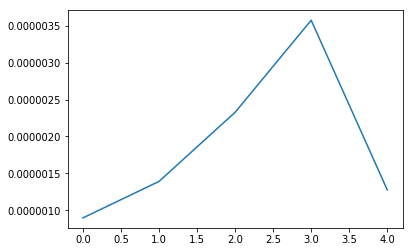

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.figure()
plt.plot(all_losses)

**Observations**:
- Interesting how much more _boring_ this n-gram output is compared to the not deep n-gram output from last week
- Training, even on a sample 2K reviews, is _slow_ (5 epochs in 67m 18s). Could we speed up with:
    - Batching
    - Adaptive learning rates (although this may make it train better but not necessarily faster)
    - Using PyTorch implementations of RNNs/LSTMs
- **TODO**: print_every 50000?

## with rnn

In [12]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_fac, order):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embeddings = nn.Embedding(vocab_size, n_fac)
        self.i2h = nn.Linear(order * n_fac + hidden_size, hidden_size)
        self.i2o = nn.Linear(order * n_fac + hidden_size, vocab_size)
        self.o2o = nn.Linear(hidden_size + vocab_size, vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    # NOTE: this example only works as-is in PyTorch 0.4+
    # https://stackoverflow.com/questions/50475094/runtimeerror-addmm-argument-mat1-position-1-must-be-variable-not-torch
    def forward(self, inputs, hidden):
        embeds = self.embeddings(inputs.cuda()).view((1, -1))
        combined_i = torch.cat((embeds, hidden.cuda()), 1)
        hidden = self.i2h(combined_i)
        output = self.i2o(combined_i)
        combined_o = torch.cat((hidden, output), 1)
        output = self.o2o(combined_o)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size).cuda() # TODO: why isn't this random?

In [13]:
def trainRNN(model, xs, ys, hidden, order=4, criterion=nn.NLLLoss(), optimizer=None):
    # TODO: switch default criterion to crossentropy_loss
    
    for i in range(xs.shape[0]):
        # Step 1. Prepare the inputs to be passed to the model
        # (i.e., wrap integer indices in variables)
        #xs_tensor = torch.tensor(xs[i], dtype=torch.long, device=cuda)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # order words
        output, hidden = model(torch.tensor(xs[i], dtype=torch.long, device=cuda), hidden)
        # detach from history of the last instance
        hidden = hidden.detach()

        # Step 4. Compute your loss function
        loss = criterion(output, torch.tensor([ys[i]], dtype=torch.long, device=cuda))
        
        # Step 5. Do the backward pass and update gradient
        loss.backward()
        if optimizer:
            optimizer.step()
        
        print_every = 5000
        if i % print_every == 0:
            print(f'{timeSince(start)} ({i} {i / xs.shape[0] * 100:.2f}%) {loss:.4f}')
    
    return output, loss.item(), hidden

In [14]:
def sampleRNN(model, order=4, max_length=20):
    with torch.no_grad(): # no need to track history in sampling
        input = '\0' * order
        hidden = model.init_hidden()

        output_idx = [char_to_idx[c] for c in input[-order:]]

        for i in range(max_length):
            h_idxs = torch.tensor(output_idx[-order:], dtype=torch.long, device=cuda)
            output, hidden = model(h_idxs, hidden)
            # sample from distribution
            output_dist = output.data.view(-1).exp()
            idx = torch.multinomial(output_dist, 1)[0].item()
            if idx == 0:
                break
            else:
                output_idx.append(idx)

        sample_text = ''.join([idx_to_char[i] for i in output_idx])
        print(sample_text)
        #print(output_idx)

In [15]:
all_losses = [] # keep track of losses for plotting

rnn = RNN(vocab_size, N_HIDDEN, N_FAC, ORDER).cuda()
hidden = rnn.init_hidden()
optimizer = optim.SGD(rnn.parameters(), lr=0.001)

start = time.time()

for epoch in range(EPOCHS):
    xs, ys, vocab_size, char_to_idx, idx_to_char = createInputs(train_text)
    output, loss, hidden = trainRNN(rnn, xs, ys, hidden, order=ORDER, optimizer=optimizer)   
    all_losses.append(loss / xs.shape[0])
    
    print(f'Epoch {epoch} sample:')
    sampleRNN(rnn, max_length=1000)
    
end = time.time()
print(f'Training time: {end-start:.2f}s')
print(all_losses)

0m 3s (0 0.00%) 5.2989
0m 9s (5000 0.45%) 4.3523
0m 14s (10000 0.89%) 3.2871
0m 19s (15000 1.34%) 1.1703
0m 25s (20000 1.79%) 1.2507
0m 30s (25000 2.23%) 6.4893
0m 35s (30000 2.68%) 4.6875
0m 40s (35000 3.13%) 0.1175
0m 46s (40000 3.58%) 0.2802
0m 51s (45000 4.02%) 3.1537
0m 56s (50000 4.47%) 1.8798
1m 2s (55000 4.92%) 3.7191
1m 7s (60000 5.36%) 2.3467
1m 12s (65000 5.81%) 2.8624
1m 18s (70000 6.26%) 4.2929
1m 23s (75000 6.70%) 1.1258
1m 28s (80000 7.15%) 0.5105
1m 34s (85000 7.60%) 2.0255
1m 39s (90000 8.05%) 1.8274
1m 44s (95000 8.49%) 3.5656
1m 50s (100000 8.94%) 2.9525
1m 55s (105000 9.39%) 0.7122
2m 0s (110000 9.83%) 1.1694
2m 6s (115000 10.28%) 1.4139
2m 11s (120000 10.73%) 0.9381
2m 16s (125000 11.17%) 4.7345
2m 22s (130000 11.62%) 5.6532
2m 27s (135000 12.07%) 4.2913
2m 32s (140000 12.52%) 6.4622
2m 38s (145000 12.96%) 4.1096
2m 43s (150000 13.41%) 2.2405
2m 48s (155000 13.86%) 3.7108
2m 53s (160000 14.30%) 2.6034
2m 59s (165000 14.75%) 3.0828
3m 4s (170000 15.20%) 1.7276
3m 9s

22m 39s (145000 12.96%) 0.6408
22m 44s (150000 13.41%) 4.4556
22m 49s (155000 13.86%) 1.7231
22m 55s (160000 14.30%) 1.6583
22m 60s (165000 14.75%) 3.7950
23m 5s (170000 15.20%) 3.6112
23m 11s (175000 15.64%) 1.6120
23m 16s (180000 16.09%) 4.3749
23m 21s (185000 16.54%) 2.9518
23m 26s (190000 16.99%) 2.1236
23m 32s (195000 17.43%) 2.8546
23m 37s (200000 17.88%) 2.4915
23m 42s (205000 18.33%) 1.5389
23m 48s (210000 18.77%) 2.1985
23m 53s (215000 19.22%) 0.9654
23m 58s (220000 19.67%) 3.9660
24m 3s (225000 20.11%) 4.9427
24m 9s (230000 20.56%) 1.7785
24m 14s (235000 21.01%) 5.2502
24m 19s (240000 21.46%) 3.0960
24m 25s (245000 21.90%) 4.2412
24m 30s (250000 22.35%) 0.6547
24m 35s (255000 22.80%) 1.3591
24m 40s (260000 23.24%) 2.2853
24m 46s (265000 23.69%) 2.8791
24m 51s (270000 24.14%) 0.7613
24m 56s (275000 24.58%) 1.7023
25m 2s (280000 25.03%) 2.3061
25m 7s (285000 25.48%) 4.6685
25m 12s (290000 25.93%) 0.6366
25m 17s (295000 26.37%) 1.1823
25m 23s (300000 26.82%) 2.4882
25m 28s (3050

46m 9s (355000 31.74%) 1.6121
46m 14s (360000 32.18%) 2.2688
46m 20s (365000 32.63%) 2.3285
46m 25s (370000 33.08%) 3.4349
46m 30s (375000 33.52%) 5.3324
46m 36s (380000 33.97%) 5.0102
46m 41s (385000 34.42%) 3.6375
46m 46s (390000 34.86%) 3.8208
46m 51s (395000 35.31%) 2.1117
46m 57s (400000 35.76%) 3.8279
47m 2s (405000 36.21%) 1.4888
47m 7s (410000 36.65%) 0.6481
47m 12s (415000 37.10%) 0.5236
47m 18s (420000 37.55%) 0.8024
47m 23s (425000 37.99%) 0.0678
47m 28s (430000 38.44%) 3.3291
47m 33s (435000 38.89%) 0.8362
47m 39s (440000 39.33%) 3.7612
47m 44s (445000 39.78%) 3.2909
47m 49s (450000 40.23%) 2.4326
47m 55s (455000 40.68%) 0.0480
47m 60s (460000 41.12%) 0.6748
48m 5s (465000 41.57%) 4.0294
48m 10s (470000 42.02%) 3.2245
48m 16s (475000 42.46%) 1.0282
48m 21s (480000 42.91%) 0.6623
48m 26s (485000 43.36%) 5.3648
48m 32s (490000 43.80%) 3.4605
48m 37s (495000 44.25%) 4.5120
48m 42s (500000 44.70%) 3.7450
48m 48s (505000 45.15%) 2.4578
48m 53s (510000 45.59%) 1.3095
48m 58s (515

68m 7s (475000 42.46%) 5.0201
68m 12s (480000 42.91%) 1.3443
68m 17s (485000 43.36%) 3.0954
68m 23s (490000 43.80%) 4.9152
68m 28s (495000 44.25%) 1.1910
68m 33s (500000 44.70%) 2.1507
68m 39s (505000 45.15%) 2.8730
68m 44s (510000 45.59%) 3.1688
68m 49s (515000 46.04%) 0.4610
68m 54s (520000 46.49%) 0.7961
68m 60s (525000 46.93%) 0.5977
69m 5s (530000 47.38%) 2.7210
69m 10s (535000 47.83%) 2.2153
69m 16s (540000 48.27%) 1.6379
69m 21s (545000 48.72%) 0.5497
69m 26s (550000 49.17%) 1.3624
69m 32s (555000 49.62%) 2.0516
69m 37s (560000 50.06%) 1.6495
69m 42s (565000 50.51%) 3.9307
69m 48s (570000 50.96%) 5.1872
69m 53s (575000 51.40%) 6.9382
69m 58s (580000 51.85%) 5.2562
70m 4s (585000 52.30%) 1.9981
70m 9s (590000 52.74%) 0.8481
70m 14s (595000 53.19%) 1.5584
70m 20s (600000 53.64%) 3.9604
70m 25s (605000 54.09%) 2.3770
70m 30s (610000 54.53%) 0.9305
70m 36s (615000 54.98%) 2.0647
70m 41s (620000 55.43%) 2.0643
70m 46s (625000 55.87%) 1.6139
70m 52s (630000 56.32%) 4.5154
70m 57s (635

90m 21s (585000 52.30%) 0.8419
90m 26s (590000 52.74%) 1.4750
90m 31s (595000 53.19%) 4.9354
90m 36s (600000 53.64%) 1.3323
90m 42s (605000 54.09%) 0.6801
90m 47s (610000 54.53%) 0.3397
90m 52s (615000 54.98%) 0.6144
90m 58s (620000 55.43%) 3.5048
91m 3s (625000 55.87%) 2.9774
91m 8s (630000 56.32%) 2.6323
91m 14s (635000 56.77%) 4.8954
91m 19s (640000 57.21%) 5.4457
91m 24s (645000 57.66%) 3.0699
91m 29s (650000 58.11%) 0.1683
91m 35s (655000 58.56%) 3.3028
91m 40s (660000 59.00%) 0.5230
91m 45s (665000 59.45%) 5.3807
91m 50s (670000 59.90%) 1.0960
91m 56s (675000 60.34%) 1.0837
92m 1s (680000 60.79%) 3.3373
92m 6s (685000 61.24%) 1.2586
92m 12s (690000 61.68%) 2.3873
92m 17s (695000 62.13%) 0.8789
92m 22s (700000 62.58%) 2.6026
92m 27s (705000 63.02%) 3.0580
92m 33s (710000 63.47%) 4.8904
92m 38s (715000 63.92%) 2.8738
92m 43s (720000 64.37%) 1.5999
92m 49s (725000 64.81%) 1.3339
92m 54s (730000 65.26%) 4.6003
92m 59s (735000 65.71%) 2.0895
93m 5s (740000 66.15%) 1.7981
93m 10s (7450

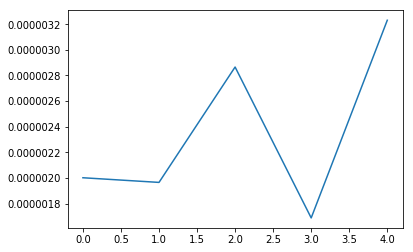

In [16]:
%matplotlib inline
plt.figure()
plt.plot(all_losses)

## with PyTorch's RNN layer

In [8]:
class PyTorchRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, order):
        super(PyTorchRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(order * hidden_size, hidden_size)
        self.l_out = nn.Linear(hidden_size, vocab_size)
        
    # NOTE: this example only works as-is in PyTorch 0.4+
    # https://stackoverflow.com/questions/50475094/runtimeerror-addmm-argument-mat1-position-1-must-be-variable-not-torch
    def forward(self, inputs, hidden):
        inputs = self.embedding(inputs.view(1, -1)) # TODO: same thing as torch.stack(inputs) ?
        output, hidden = self.rnn(inputs.view(1, 1, -1), hidden)
        output = self.l_out(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        # 1 rnn layer, 1 batch
        return torch.zeros(1, 1, self.hidden_size).cuda()

In [9]:
def trainPyTorchRNN(model, xs, ys, hidden, criterion=nn.CrossEntropyLoss(), optimizer=None):
    for i in range(xs.shape[0]):
        # Step 1. Prepare the inputs to be passed to the model
        # (i.e., wrap integer indices in variables)
        #xs_tensor = torch.tensor(xs[i], dtype=torch.long, device=cuda)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # order words
        output, hidden = model(torch.tensor(xs[i], dtype=torch.long, device=cuda), hidden)
        # detach from history of the last instance
        hidden = hidden.detach()

        # Step 4. Compute your loss function
        loss = criterion(output, torch.tensor([ys[i]], dtype=torch.long, device=cuda))
        
        # Step 5. Do the backward pass and update gradient
        loss.backward()
        if optimizer:
            optimizer.step()
        
        print_every = 5000
        if i % print_every == 0:
            print(f'{timeSince(start)} ({i} {i / xs.shape[0] * 100:.2f}%) {loss:.4f}')
    
    return output, loss.item(), hidden

In [16]:
all_losses = [] # keep track of losses for plotting

prnn = PyTorchRNN(vocab_size, N_HIDDEN, ORDER).cuda()
hidden = prnn.init_hidden()
optimizer = optim.Adam(prnn.parameters(), lr=0.005)

start = time.time()

for epoch in range(EPOCHS):
    xs, ys, vocab_size, char_to_idx, idx_to_char = createInputs(train_text)
    output, loss, hidden = trainPyTorchRNN(prnn, xs, ys, hidden, optimizer=optimizer)   
    all_losses.append(loss / xs.shape[0])
    
    print(f'Epoch {epoch} sample:')
    sampleRNN(prnn, max_length=1000)
    
end = time.time()
print(f'Training time: {end-start:.2f}s')
print(all_losses)

0m 4s (0 0.00%) 4.4079
0m 12s (5000 0.45%) 3.4969
0m 20s (10000 0.89%) 3.2278
0m 28s (15000 1.34%) 0.6362
0m 36s (20000 1.79%) 4.3301
0m 45s (25000 2.23%) 1.0218
0m 53s (30000 2.68%) 2.1469
1m 1s (35000 3.13%) 1.3655
1m 10s (40000 3.58%) 0.1298
1m 21s (45000 4.02%) 2.9689
1m 31s (50000 4.47%) 6.0725
1m 41s (55000 4.92%) 1.7463
1m 52s (60000 5.36%) 3.1393
2m 3s (65000 5.81%) 5.1951
2m 14s (70000 6.26%) 4.3095
2m 25s (75000 6.70%) 7.4724
2m 34s (80000 7.15%) 9.3089
2m 43s (85000 7.60%) 3.5841
2m 54s (90000 8.05%) 4.8790
3m 5s (95000 8.49%) 0.1864
3m 15s (100000 8.94%) 2.7816
3m 25s (105000 9.39%) 5.7865
3m 36s (110000 9.83%) 6.7808
3m 46s (115000 10.28%) 3.3876
3m 58s (120000 10.73%) 15.3100
4m 8s (125000 11.17%) 6.0979
4m 19s (130000 11.62%) 0.0502
4m 29s (135000 12.07%) 7.1790
4m 39s (140000 12.51%) 6.2310
4m 49s (145000 12.96%) 2.5127
4m 60s (150000 13.41%) 0.1391
5m 10s (155000 13.86%) 3.9077
5m 20s (160000 14.30%) 3.7596
5m 29s (165000 14.75%) 7.9176
5m 38s (170000 15.20%) 3.2808
5m

33m 44s (65000 5.81%) 3.8602
33m 54s (70000 6.26%) 2.5854
34m 4s (75000 6.70%) 11.7825
34m 14s (80000 7.15%) 4.2863
34m 24s (85000 7.60%) 1.4236
34m 34s (90000 8.05%) 4.3325
34m 45s (95000 8.49%) 5.2842
34m 53s (100000 8.94%) 2.6289
35m 1s (105000 9.39%) 0.2620
35m 9s (110000 9.83%) 2.8879
35m 18s (115000 10.28%) 3.7108
35m 26s (120000 10.73%) 4.1298
35m 34s (125000 11.17%) 4.8325
35m 42s (130000 11.62%) 5.7999
35m 51s (135000 12.07%) 2.4807
35m 59s (140000 12.51%) 11.0984
36m 7s (145000 12.96%) 0.1039
36m 15s (150000 13.41%) 3.5470
36m 24s (155000 13.86%) 4.0063
36m 32s (160000 14.30%) 1.3748
36m 41s (165000 14.75%) 3.3189
36m 51s (170000 15.20%) 5.7723
37m 1s (175000 15.64%) 6.2105
37m 11s (180000 16.09%) 0.0103
37m 22s (185000 16.54%) 2.0094
37m 32s (190000 16.98%) 1.7610
37m 42s (195000 17.43%) 1.4746
37m 52s (200000 17.88%) 3.4039
38m 3s (205000 18.32%) 6.8587
38m 13s (210000 18.77%) 6.4358
38m 23s (215000 19.22%) 3.2590
38m 33s (220000 19.67%) 1.9990
38m 42s (225000 20.11%) 2.763

74m 4s (115000 10.28%) 3.3408
74m 19s (120000 10.73%) 0.0374
74m 35s (125000 11.17%) 0.4320
74m 50s (130000 11.62%) 1.6662
75m 5s (135000 12.07%) 5.3014
75m 20s (140000 12.51%) 3.4859
75m 35s (145000 12.96%) 0.7766
75m 50s (150000 13.41%) 3.1190
76m 5s (155000 13.86%) 1.5246
76m 20s (160000 14.30%) 2.1898
76m 35s (165000 14.75%) 1.9313
76m 50s (170000 15.20%) 0.2705
77m 6s (175000 15.64%) 2.6479
77m 21s (180000 16.09%) 11.4298
77m 36s (185000 16.54%) 3.8889
77m 51s (190000 16.98%) 7.4024
78m 7s (195000 17.43%) 2.2208
78m 22s (200000 17.88%) 5.6641
78m 37s (205000 18.32%) 4.4730
78m 52s (210000 18.77%) 4.3365
79m 8s (215000 19.22%) 2.8619
79m 23s (220000 19.67%) 3.1034
79m 39s (225000 20.11%) 3.7249
79m 53s (230000 20.56%) 2.1190
80m 8s (235000 21.01%) 2.1601
80m 24s (240000 21.45%) 3.1188
80m 39s (245000 21.90%) 0.0228
80m 54s (250000 22.35%) 0.0012
81m 9s (255000 22.79%) 3.4566
81m 24s (260000 23.24%) 0.4976
81m 39s (265000 23.69%) 3.2376
81m 54s (270000 24.14%) 0.1474
82m 9s (275000 

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCStorage.c:36

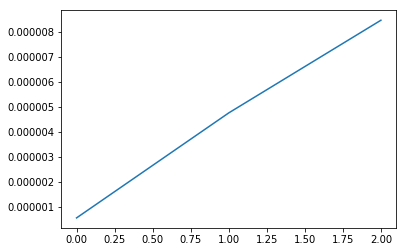

In [18]:
%matplotlib inline
plt.figure()
plt.plot(all_losses)

## Known issues so far
- No batching
- No model saving
- No torchtext